This is a short example to show you how to use Deep Learning with fastai to solve the well known titanic dataset. There are some advanced configurations via callbacks just to give you some directions to look into in more detail. The data can be found on kaggle (https://www.kaggle.com/c/titanic/data). There are also some tutorials how to prepare your data to improve accuracy. Obviously the following modell is not optimized but gets an accuracy of more than 80% (but make sure to look at other metrics as well). 

In [1]:
import pandas as pd
import numpy as np
import fastai
import fastai
from fastai.callbacks import *
from fastai.tabular import *

from sklearn.model_selection import train_test_split

# Read data

In [2]:
df = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')

df.Sex = df.Sex.astype('category')
df.Cabin = df.Cabin.astype('category')
df.Embarked = df.Embarked.astype('category')

X_train, X_valid = train_test_split(df)
train_idx = X_train.index.values
valid_idx = X_valid.index.values

# Prepare data

In [3]:
#TODO: your data preparation and feature engineering goes here
df = df.drop(['PassengerId','Name','Ticket'], axis=1, errors='ignore')
df.Cabin = df.Cabin.apply(lambda c: str(c)[0])

df_test = df_test.drop(['PassengerId','Name','Ticket'], axis=1, errors='ignore')
df_test.Cabin = df_test.Cabin.apply(lambda c: str(c)[0])

# Model building and training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.20E-02


epoch,train_loss,valid_loss,accuracy,time
0,0.699450,0.690586,0.542601,00:00
1,0.672679,0.646493,0.739910,00:00
2,0.631828,0.525994,0.784753,00:00
3,0.584930,0.452496,0.802691,00:00
4,0.552897,0.439660,0.807175,00:00
5,0.526698,0.432390,0.838565,00:00
6,0.509020,0.517549,0.807175,00:00
7,0.495809,0.433742,0.825112,00:00
8,0.485432,0.457493,0.811659,00:00
9,0.474073,0.504623,0.807175,00:00


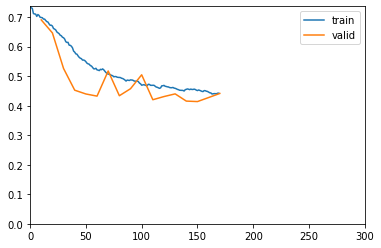

Better model found at epoch 0 with accuracy value: 0.5426008701324463.
Better model found at epoch 1 with accuracy value: 0.7399103045463562.
Better model found at epoch 2 with accuracy value: 0.7847533822059631.
Better model found at epoch 3 with accuracy value: 0.8026905655860901.
Better model found at epoch 4 with accuracy value: 0.8071748614311218.
Better model found at epoch 5 with accuracy value: 0.8385650515556335.
Epoch 6: reducing lr to 0.005878910756751686
Epoch 7: reducing lr to 0.0064309137885685715
Epoch 8: reducing lr to 0.006622622429651816
Epoch 9: reducing lr to 0.006585637967209186
Epoch 11: reducing lr to 0.006294700843011783
Epoch 12: reducing lr to 0.006047247235852456
Epoch 15: reducing lr to 0.004966973444861292
Epoch 16: reducing lr to 0.004521077452259873
Epoch 16: early stopping


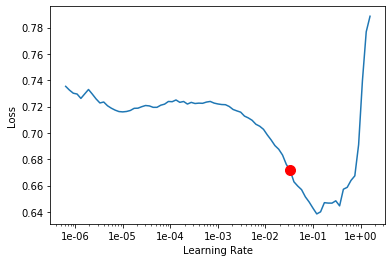

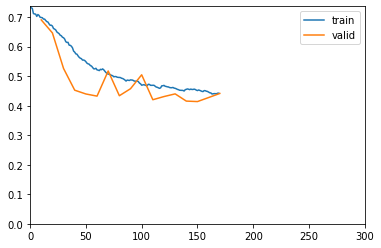

In [4]:
# Create databunch
procs = [FillMissing, Categorify, Normalize]
cat_vars = ['Sex', 'Cabin', 'Embarked']
data = TabularDataBunch.from_df(path='', df=df, dep_var='Survived', valid_idx=valid_idx, procs=procs, cat_names=cat_vars)

# Create learner
learn = tabular_learner(data, [64, 32], metrics=[fastai.metrics.accuracy], ps=[0.5,0.25], wd=0.001, callback_fns=ShowGraph)

# Find the "best" lr to start
learn.lr_find()
learn.recorder.plot(suggestion=True)

# Save the best model while training (highest accuracy)
saveModelCallback = SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best_model_titanic')
# Reduce LR if stuck on a plateau
reduceLROnPlateauCallback = ReduceLROnPlateauCallback(learn, monitor='valid_loss')
# Stop if accuracy hasn't improve the last 10 epochs
earlyStoppingCallback = EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.01, patience=10)

# Train the model with some registered callbacks using one cycle fit policy
learn.fit_one_cycle(30, max_lr=learn.recorder.min_grad_lr, callbacks=[saveModelCallback, reduceLROnPlateauCallback, earlyStoppingCallback])

# Validate

In [5]:
# Load the best model, validate and save the metrics of this fold to the list
learn = learn.load(f'best_model_titanic')
probs, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, probs, y, losses)

In [6]:
from sklearn.metrics import *
print(interp.confusion_matrix())
print(classification_report(y, interp.pred_class))

[[133  11]
 [ 25  54]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       144
           1       0.83      0.68      0.75        79

    accuracy                           0.84       223
   macro avg       0.84      0.80      0.82       223
weighted avg       0.84      0.84      0.83       223

